# Vodafone churn analysis and modelling

## Load dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
Database = pd.read_csv("C:\\Users\\Bator\\Desktop\\Bator\\Munka új\\Vodafone\\telco (1).csv", sep=',',decimal='.')
Database.head()

,region,tenure,age,marital,address,income,ed,employ,retire,gender,...,voice,pager,internet,callid,callwait,forward,confer,ebill,custcat,churn
0,2,13,44,1,9,64.0,4,5,0.0,0,...,0,0,0,0,0,1,0,0,1,1
1,3,11,33,1,7,136.0,5,5,0.0,0,...,1,1,0,1,1,1,1,0,4,1
2,3,68,52,1,24,116.0,1,29,0.0,1,...,0,0,0,1,1,0,1,0,3,0
3,2,33,33,0,12,33.0,2,0,0.0,1,...,0,0,0,0,0,0,0,0,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,...,0,0,0,1,0,1,1,0,3,0


## Data preparation

- Missing value treatment
- Outlier treatment
- Checking data quality (common sense)
- Data transformation
    - continuous variables -> standardization
    - categorical variables -> One-hot encoding (if there are too many distinct values, some columns should be merged based on common sense and churn rate)
    - flag variables -> leave as it is (but apply missing value treatment if necessary)
    - ordinal variables -> Further analysis required how to treat it 
    

We could have used WOE (weight of evidence) transformation (Fine and Coarse classing) to transform the data, but it requires a lot more time  to do it in Python. It is a great approach, because it handles missing values, outlier treatment and can be used on all types of variables (ordinal, boolean, categorical, continuous). It might do not have signifant effect on the final model, but this could be a potential improvement area in the future.

#### First 10 variable

In [2]:
Database[['region','tenure','age','marital','address','income','ed','employ','retire','gender']].describe(include="all")

,region,tenure,age,marital,address,income,ed,employ,retire,gender
count,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.0220,35.526000,41.684000,0.495000,11.551000,77.535000,2.671000,10.987000,0.047000,0.517000
std,0.8162,21.359812,12.558816,0.500225,10.086681,107.044165,1.222397,10.082087,0.211745,0.499961
min,1.0000,1.000000,18.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000
25%,1.0000,17.000000,32.000000,0.000000,3.000000,29.000000,2.000000,3.000000,0.000000,0.000000
50%,2.0000,34.000000,40.000000,0.000000,9.000000,47.000000,3.000000,8.000000,0.000000,1.000000
75%,3.0000,54.000000,51.000000,1.000000,18.000000,83.000000,4.000000,17.000000,0.000000,1.000000
max,3.0000,72.000000,77.000000,1.000000,55.000000,1668.000000,5.000000,47.000000,1.000000,1.000000


In [3]:
print(Database['region'].isna().sum())
print(Database['tenure'].isna().sum())
print(Database['age'].isna().sum())
print(Database['marital'].isna().sum())
print(Database['address'].isna().sum())
print(Database['income'].isna().sum())
print(Database['ed'].isna().sum())
print(Database['employ'].isna().sum())
print(Database['retire'].isna().sum())
print(Database['gender'].isna().sum())

0
0
0
0
0
0
0
0
0
0


The data quality is good, there aren't any missing value in the first 10 explanatory variables and the variable distributions seems ok as well. The max value of 'income' variable seems high (but can be realistic), it might be worth to apply outlier treatment.

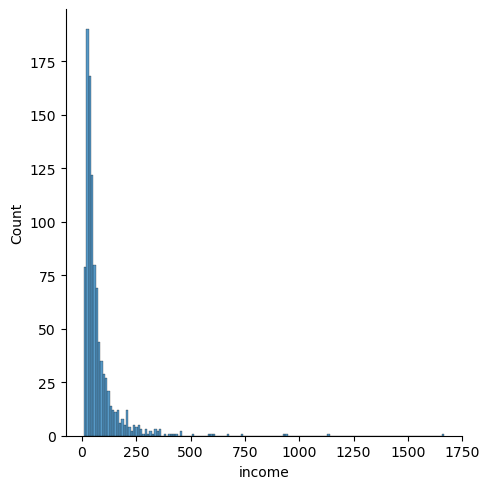

In [4]:
import seaborn as sns
sns.displot(Database, x="income")
plt.show()

The high 'income' values (above 400-500) are quite uncommon in the database, therefore I will repleace them with the 98th quantile of the variable. Using this outlier treatment the high income values won't distort the model results.

In [5]:
Database.income.quantile(0.98)

351.15999999999985

In [6]:
Database.loc[Database['income'] > 351.159, 'income'] = 351.159

In [7]:
Database.income.mean()

72.12817999999999

#### Second 10 variables

In [8]:
Database[['reside','tollfree','equip','callcard','wireless','longmon','tollmon','equipmon','cardmon','wiremon']].describe(include="all")

,reside,tollfree,equip,callcard,wireless,longmon,tollmon,equipmon,cardmon,wiremon
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.331000,0.474000,0.386000,0.678000,0.296000,11.723100,13.274000,14.219800,13.781000,11.583900
std,1.435793,0.499573,0.487074,0.467477,0.456719,10.363486,16.902122,19.068539,14.084496,19.719426
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.900000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,5.200000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,1.000000,0.000000,8.525000,0.000000,0.000000,12.000000,0.000000
75%,3.000000,1.000000,1.000000,1.000000,1.000000,14.412500,24.250000,31.475000,20.500000,24.712500
max,8.000000,1.000000,1.000000,1.000000,1.000000,99.950000,173.000000,77.700000,109.250000,111.950000


In [9]:
print(Database['reside'].isna().sum())
print(Database['tollfree'].isna().sum())
print(Database['equip'].isna().sum())
print(Database['callcard'].isna().sum())
print(Database['wireless'].isna().sum())
print(Database['longmon'].isna().sum())
print(Database['tollmon'].isna().sum())
print(Database['equipmon'].isna().sum())
print(Database['cardmon'].isna().sum())
print(Database['wiremon'].isna().sum())

0
0
0
0
0
0
0
0
0
0


The data quality is good, there aren't any missing value in the second 10 explanatory variables and the variable distributions seems ok as well.

#### Third 10 variables

In [10]:
Database[['longten','tollten','equipten','cardten','wireten','multline','voice','pager','internet','callid']].describe(include="all")

,longten,tollten,equipten,cardten,wireten,multline,voice,pager,internet,callid
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000
mean,574.050050,551.258500,465.632850,605.773750,442.736900,0.475000,0.304000,0.2610,0.368000,0.481000
std,789.974346,915.746733,857.273071,830.126069,971.471264,0.499624,0.460213,0.4394,0.482503,0.499889
min,0.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
25%,90.137500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
50%,285.475000,0.000000,0.000000,332.500000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
75%,755.025000,846.900000,579.450000,910.000000,316.500000,1.000000,1.000000,1.0000,1.000000,1.000000
max,7257.600000,5916.000000,5028.650000,7515.000000,7856.850000,1.000000,1.000000,1.0000,1.000000,1.000000


In [11]:
print(Database['longten'].isna().sum())
print(Database['tollten'].isna().sum())
print(Database['equipten'].isna().sum())
print(Database['cardten'].isna().sum())
print(Database['wireten'].isna().sum())
print(Database['multline'].isna().sum())
print(Database['voice'].isna().sum())
print(Database['pager'].isna().sum())
print(Database['internet'].isna().sum())
print(Database['callid'].isna().sum())

0
0
0
0
0
0
0
0
0
0


The data quality is good, there aren't any missing value in the third 10 explanatory variables and the variable distributions seems ok as well. Tenure based variables have very high max values, further distribution analysis required to decide whether outlier treatment should be used or not.

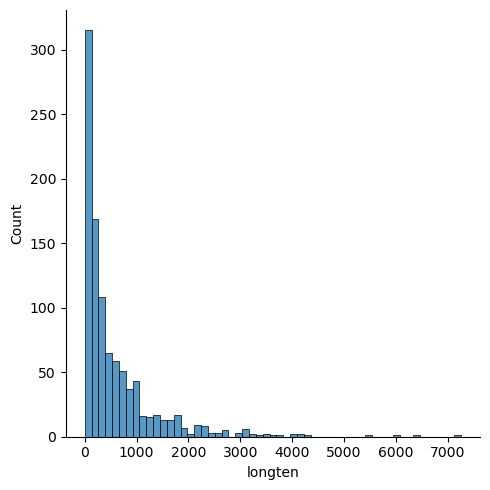

In [12]:
import seaborn as sns
sns.displot(Database, x="longten")
plt.show()

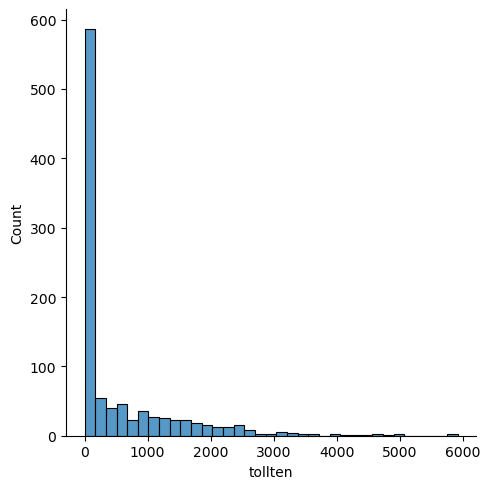

In [13]:
import seaborn as sns
sns.displot(Database, x="tollten")
plt.show()

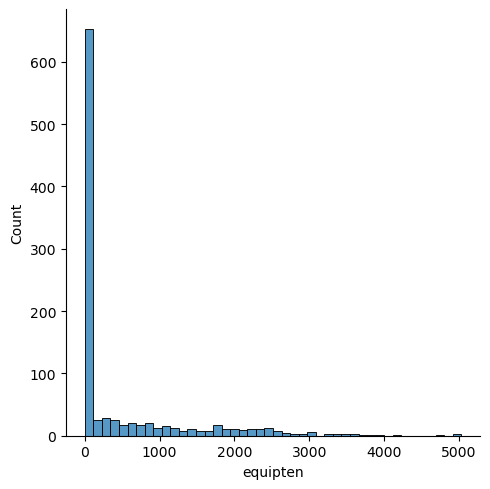

In [14]:
import seaborn as sns
sns.displot(Database, x="equipten")
plt.show()

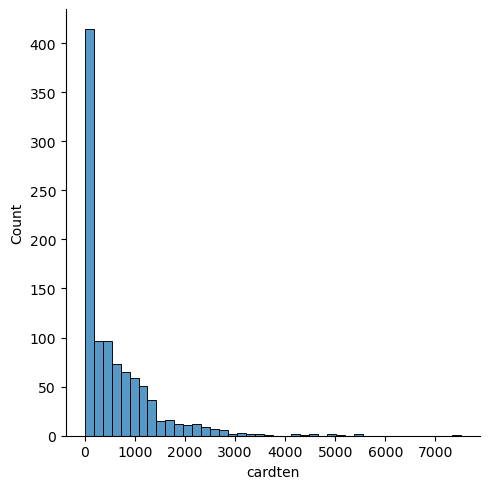

In [15]:
import seaborn as sns
sns.displot(Database, x="cardten")
plt.show()

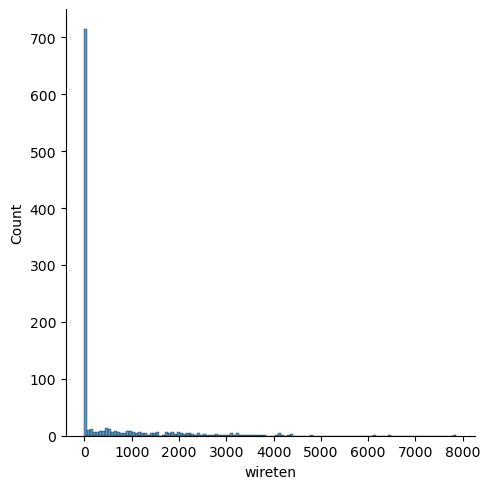

In [16]:
import seaborn as sns
sns.displot(Database, x="wireten")
plt.show()

The extremely high values are quite rare for this variables, therefore I will replace the values over 98th percentile, with the value of the 98th percentile to avoid possible distortion in the model.

In [17]:
Database.longten.quantile(0.98)

3043.8059999999996

In [18]:
Database.tollten.quantile(0.98)

3258.753999999999

In [19]:
Database.equipten.quantile(0.98)

3013.7

In [20]:
Database.cardten.quantile(0.98)

2865.899999999999

In [21]:
Database.wireten.quantile(0.98)

3613.9719999999998

In [22]:
Database.loc[Database['longten'] > 3043.8, 'longten'] = 3043.8
Database.loc[Database['tollten'] > 3258.75, 'tollten'] = 3258.75
Database.loc[Database['equipten'] > 3013.7, 'equipten'] = 3013.7
Database.loc[Database['cardten'] > 2865.89, 'cardten'] = 2865.89
Database.loc[Database['wireten'] > 3613.9, 'wireten'] = 3613.9

In [23]:
Database[['longten','tollten','equipten','cardten','wireten','multline','voice','pager','internet','callid']].describe(include="all")

,longten,tollten,equipten,cardten,wireten,multline,voice,pager,internet,callid
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000
mean,552.473000,530.919250,451.952500,578.42655,424.827800,0.475000,0.304000,0.2610,0.368000,0.481000
std,682.615558,834.270925,805.369569,708.61030,889.818874,0.499624,0.460213,0.4394,0.482503,0.499889
min,0.900000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
25%,90.137500,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
50%,285.475000,0.000000,0.000000,332.50000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
75%,755.025000,846.900000,579.450000,910.00000,316.500000,1.000000,1.000000,1.0000,1.000000,1.000000
max,3043.800000,3258.750000,3013.700000,2865.89000,3613.900000,1.000000,1.000000,1.0000,1.000000,1.000000


#### Rest of the variables 

In [24]:
Database[['callwait','forward','confer','ebill','custcat']].describe(include="all")

,callwait,forward,confer,ebill,custcat
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.485000,0.493000,0.502000,0.371000,2.487000
std,0.500025,0.500201,0.500246,0.483314,1.120306
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,0.000000,3.000000
75%,1.000000,1.000000,1.000000,1.000000,3.000000
max,1.000000,1.000000,1.000000,1.000000,4.000000


In [25]:
print(Database['callwait'].isna().sum())
print(Database['forward'].isna().sum())
print(Database['confer'].isna().sum())
print(Database['ebill'].isna().sum())
print(Database['custcat'].isna().sum())

0
0
0
0
0


The data quality is good, there aren't any missing value in the rest of the explanatory variables and the variable distributions seems ok as well.

### Data transformation

#### Standardization

In [26]:
import scipy
from scipy import stats

In [27]:
Database['tenure_std'] = stats.zscore(Database['tenure'])
Database['age_std'] = stats.zscore(Database['age'])
Database['address_std'] = stats.zscore(Database['address'])
Database['income_std'] = stats.zscore(Database['income'])
Database['employ_std'] = stats.zscore(Database['employ'])
Database['reside_std'] = stats.zscore(Database['reside'])
Database['longmon_std'] = stats.zscore(Database['longmon'])
Database['tollmon_std'] = stats.zscore(Database['tollmon'])
Database['equipmon_std'] = stats.zscore(Database['equipmon'])
Database['cardmon_std'] = stats.zscore(Database['cardmon'])
Database['wiremon_std'] = stats.zscore(Database['wiremon'])
Database['longten_std'] = stats.zscore(Database['longten'])
Database['tollten_std'] = stats.zscore(Database['tollten'])
Database['equipten_std'] = stats.zscore(Database['equipten'])
Database['cardten_std'] = stats.zscore(Database['cardten'])
Database['wireten_std'] = stats.zscore(Database['wireten'])

#### Categorical variables

In [28]:
Database.churn.mean()

0.274

In [29]:
Database.groupby('region', as_index=False)['churn'].mean()

,region,churn
0,1,0.279503
1,2,0.281437
2,3,0.261628


Churn rate is similar in each of the categories, one-hot onecoding can be used, but probably won't be an useful variable.

In [30]:
Database.loc[Database['region'] == 1, 'region'] = "region_1"
Database.loc[Database['region'] == 2, 'region'] = "region_2"
Database.loc[Database['region'] == 3, 'region'] = "region_3"

In [31]:
df_region = pd.get_dummies(Database['region'])

In [32]:
Database = pd.concat([Database, df_region], axis=1)

In [33]:
Database.head()

,region,tenure,age,marital,address,income,ed,employ,retire,gender,...,cardmon_std,wiremon_std,longten_std,tollten_std,equipten_std,cardten_std,wireten_std,region_1,region_2,region_3
0,region_2,13,44,1,9,64.0,4,5,0.0,0,...,-0.446174,-0.587730,-0.754862,-0.636706,-0.561455,-0.661380,-0.477671,0,1,0
1,region_3,11,33,1,7,136.0,5,5,0.0,0,...,0.104351,1.223574,-0.748193,-0.383124,-0.561455,-0.640202,-0.050010,0,0,1
2,region_3,68,52,1,24,116.0,1,29,0.0,1,...,1.169885,-0.587730,1.096520,0.859001,-0.561455,2.218934,-0.477671,0,0,1
3,region_2,33,33,0,12,33.0,2,0,0.0,1,...,-0.978941,-0.587730,-0.386462,-0.636706,-0.561455,-0.816691,-0.477671,0,1,0
4,region_2,23,30,1,9,30.0,1,2,0.0,0,...,-0.978941,-0.587730,-0.579566,-0.636706,-0.561455,-0.816691,-0.477671,0,1,0


In [34]:
Database.groupby('custcat', as_index=False)['churn'].mean()

,custcat,churn
0,1,0.312030
1,2,0.271889
2,3,0.156584
3,4,0.372881


In [35]:
Database.groupby('custcat', as_index=False)['custcat'].count()

,custcat
0,266
1,217
2,281
3,236


Custcat variable can be really useful, because each of the bins have an acceptable number of observations and churn rates are significantly different in each group. One-hot encoding can be used on this variable.

In [36]:
Database.loc[Database['custcat'] == 1, 'custcat'] = "custcat_1"
Database.loc[Database['custcat'] == 2, 'custcat'] = "custcat_2"
Database.loc[Database['custcat'] == 3, 'custcat'] = "custcat_3"
Database.loc[Database['custcat'] == 4, 'custcat'] = "custcat_4"

In [37]:
df_custcat = pd.get_dummies(Database['custcat'])

In [38]:
Database = pd.concat([Database, df_custcat], axis=1)

In [39]:
Database.head()

,region,tenure,age,marital,address,income,ed,employ,retire,gender,...,equipten_std,cardten_std,wireten_std,region_1,region_2,region_3,custcat_1,custcat_2,custcat_3,custcat_4
0,region_2,13,44,1,9,64.0,4,5,0.0,0,...,-0.561455,-0.661380,-0.477671,0,1,0,1,0,0,0
1,region_3,11,33,1,7,136.0,5,5,0.0,0,...,-0.561455,-0.640202,-0.050010,0,0,1,0,0,0,1
2,region_3,68,52,1,24,116.0,1,29,0.0,1,...,-0.561455,2.218934,-0.477671,0,0,1,0,0,1,0
3,region_2,33,33,0,12,33.0,2,0,0.0,1,...,-0.561455,-0.816691,-0.477671,0,1,0,1,0,0,0
4,region_2,23,30,1,9,30.0,1,2,0.0,0,...,-0.561455,-0.816691,-0.477671,0,1,0,0,0,1,0


#### Ordinal variable

In [40]:
Database.groupby('ed', as_index=False)['churn'].mean()

,ed,churn
0,1,0.156863
1,2,0.219512
2,3,0.282297
3,4,0.393162
4,5,0.424242


'ed' is a very useful variable, the 5 bins have 5 significantly different churn rate and the churn rates grow monotonically. If the churn rates were not monoton, we should have used one-hot encoding (some algorithms e.g. logistic regression can't treat non monoton variables properly). Although it might not necessary, I will use standardization on this variable to make it centered around zero like the other continuous variables.

In [41]:
Database['ed_std'] = stats.zscore(Database['ed'])

After data preparation, we only have boolean or standardized variables. It is an interesting question whether to standardise boolean variables or not, I decided not no do it, because in my opinion it won't distorte the algorithms, that are plan to use (Logistic regression, Random Forest, Neural Network).

## Single variable analysis

During single variable analysis, we would like to find the variables, which can explain churn cases. To select which are the most useful variables from modelling point of view, I will prepare two analyses.
- Single variable Gini calculation
- Correlation with churn

Based on these calculations, we can put the variables in order to check which of them can explain churn cases on itself the best.
Although it is an important input for modelling, the results can be used for business purposes as well. Sometimes we can identify segments that we should focus on only based on single variable analyses. 

Original database contained 35 explanatory variables.
After data preparation due to one-hot encoding, there are a bit more, 40 variables.

In [42]:
Database2=Database[['region_1','region_2','region_3','tenure_std','age_std','marital','address_std','income_std','ed_std','employ_std'
                    ,'retire','gender','reside_std','tollfree','equip','callcard','wireless','longmon_std','tollmon_std','equipmon_std'
                    ,'cardmon_std','wiremon_std','longten_std','tollten_std','equipten_std','cardten_std','wireten_std','multline','voice','pager'
                    ,'internet','callid','callwait','forward','confer','ebill','custcat_1','custcat_2','custcat_3','custcat_4','churn']]

In [43]:
Database2.head()

,region_1,region_2,region_3,tenure_std,age_std,marital,address_std,income_std,ed_std,employ_std,...,callid,callwait,forward,confer,ebill,custcat_1,custcat_2,custcat_3,custcat_4,churn
0,0,1,0,-1.055125,0.184505,1,-0.253034,-0.115701,1.087753,-0.594123,...,0,0,1,0,0,1,0,0,0,1
1,0,0,1,-1.148806,-0.691812,1,-0.451415,0.909184,1.906227,-0.594123,...,1,1,1,1,0,0,0,0,1,1
2,0,0,1,1.521092,0.821826,1,1.234819,0.624494,-1.367671,1.787528,...,1,1,0,1,0,0,0,1,0,0
3,0,1,0,-0.118319,-0.691812,0,0.044536,-0.556970,-0.549196,-1.090300,...,0,0,0,0,0,1,0,0,0,1
4,0,1,0,-0.586722,-0.930808,1,-0.253034,-0.599674,-1.367671,-0.891829,...,1,0,1,1,0,0,0,1,0,0


#### Single variable Gini calculation

Gini values should be interpreted by absolute values. High positive Gini value means, that the higher is the variable value, the higher the churn rate will be. (Vica versa for very low negative Gini values) 

In [44]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

def single_Gini(df,predicted,predictor):
    predictor1=np.asarray(df[predictor])
    predicted1=np.asarray(df[predicted])
    roc=roc_auc_score(predicted1, predictor1)
    gini=2*roc-1
    print(gini)

In [45]:
single_Gini(Database2,'churn','region_1')
single_Gini(Database2,'churn','region_2')
single_Gini(Database2,'churn','region_3')
single_Gini(Database2,'churn','tenure_std')
single_Gini(Database2,'churn','age_std')
single_Gini(Database2,'churn','marital')
single_Gini(Database2,'churn','address_std')
single_Gini(Database2,'churn','income_std')
single_Gini(Database2,'churn','ed_std')
single_Gini(Database2,'churn','employ_std')

0.008907924634533604
0.012487181033962846
-0.02139510566849656
-0.4930325149303252
-0.3284118557841187
-0.04338340270656138
-0.3224648609519213
-0.13660493454786748
0.25669099756690983
-0.36034364883070924


In [46]:
single_Gini(Database2,'churn','retire')
single_Gini(Database2,'churn','gender')
single_Gini(Database2,'churn','reside_std')
single_Gini(Database2,'churn','tollfree')
single_Gini(Database2,'churn','equip')
single_Gini(Database2,'churn','callcard')
single_Gini(Database2,'churn','wireless')
single_Gini(Database2,'churn','longmon_std')
single_Gini(Database2,'churn','tollmon_std')
single_Gini(Database2,'churn','equipmon_std')

-0.04965715549657146
0.006746295067463048
0.007460135529146816
-0.02451187388148235
0.3329713860569865
-0.2552331543705133
0.13520741589752872
-0.4299933642999336
-0.08715891496249828
0.302396895296696


In [47]:
single_Gini(Database2,'churn','cardmon_std')
single_Gini(Database2,'churn','wiremon_std')
single_Gini(Database2,'churn','longten_std')
single_Gini(Database2,'churn','tollten_std')
single_Gini(Database2,'churn','equipten_std')
single_Gini(Database2,'churn','cardten_std')
single_Gini(Database2,'churn','wireten_std')
single_Gini(Database2,'churn','multline')
single_Gini(Database2,'churn','voice')
single_Gini(Database2,'churn','pager')

-0.23293820755665473
0.1256711105748931
-0.4913886710502503
-0.12173493394462198
0.24851702157607924
-0.386700448412459
0.09262834047173785
-0.01583519334017014
0.16440449618949948
0.12811928173573817


In [48]:
single_Gini(Database2,'churn','internet')
single_Gini(Database2,'churn','callid')
single_Gini(Database2,'churn','callwait')
single_Gini(Database2,'churn','forward')
single_Gini(Database2,'churn','confer')
single_Gini(Database2,'churn','ebill')
single_Gini(Database2,'churn','custcat_1')
single_Gini(Database2,'churn','custcat_2')
single_Gini(Database2,'churn','custcat_3')
single_Gini(Database2,'churn','custcat_4')

0.2924131829241319
-0.024099656150087356
-0.069825662061893
-0.02052039975065867
-0.0731334580040619
0.2782268605095415
0.050853592326717934
-0.0023023868412056503
-0.16586233938589612
0.11731113390038406


Observations based on the results:
   - Strongest predictor: tenure -> clients with long service time are less likely to leave the portfolio
   - Very strong pedictor: longten, longmon -> clients with lot of long distance calls are less likely to leave the portfolio, it seems it is a business area where Vodafone pricing or service is well appreciated by clients
   - Strong pedictor: employ -> clients, which are loyal to their workplace are less likely to change telco service provider as well
   - Strong pedictor: cardten, cardmon -> Frequent calling card users are less likely to leave the portfolio
   - Good predictor: equip, equipmon -> Client with equipment usage are more likely to leave the portfolio, it should be an area to improve the service
   - Good predictor: age -> younger clients are more likely to leave the portfolio as expected mainly due to the fact, that they are more mobile
   - Good predictor: address -> clients, who live at their current address since many years are less likely to leave the portfolio
   - Good predictor: internet -> clients, with internet service are more likely to leave the portfolio, it should be an area to improve the service

The following chart can help us to check a variable, if we suspect non monoton relationship between the predictor and the target variable. E.g. I was worried, that age might not have non monoton realationship with churn, but it turned out to be ok.  

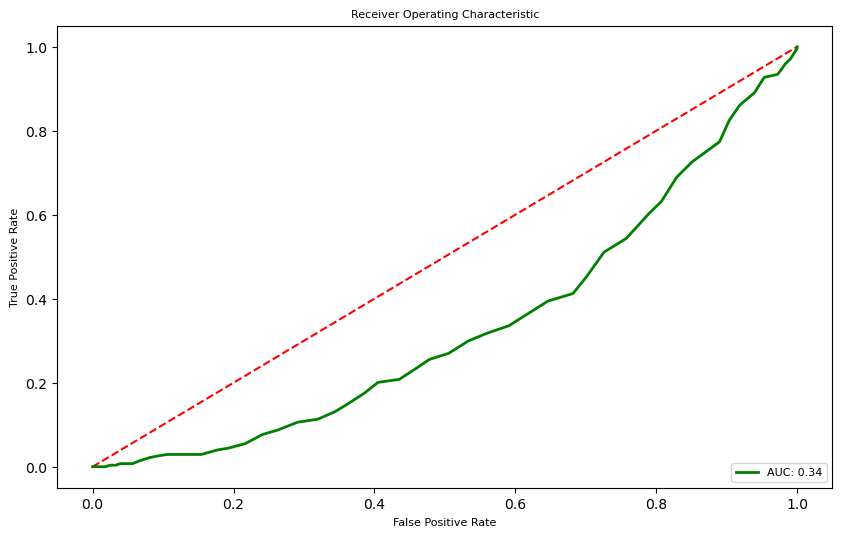

In [49]:
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (10, 6))
plt.plot([0,1], [0,1], 'r--')


fpr, tpr, thresholds = roc_curve(np.asarray(Database2['churn']), np.asarray(Database2['age_std']))
roc_auc = auc(fpr, tpr)

label = 'AUC:' + ' {0:.2f}'.format(roc_auc)
plt.plot(fpr, tpr, c = 'g', label = label, linewidth = 2)
plt.xlabel('False Positive Rate', fontsize = 8)
plt.ylabel('True Positive Rate', fontsize = 8)
plt.title('Receiver Operating Characteristic', fontsize = 8)
plt.legend(loc = 'lower right', fontsize = 8)

plt.show()

#### Correlation

Using the following correlation table, we can see which variables are the most correlated with churn (negative correlation is useful information as well). Using the table we can check the correlations for each variable pair and this can be very useful during modelling. It is a bit hard to treat and visualize 41x41 correlation table in python, therefore I usually use a copy to clipboard code to check it in an excel sheet. I will attach the correlation excel sheet too.

In [50]:
Database2.corr()

,region_1,region_2,region_3,tenure_std,age_std,marital,address_std,income_std,ed_std,employ_std,...,callid,callwait,forward,confer,ebill,custcat_1,custcat_2,custcat_3,custcat_4,churn
region_1,1.000000,-0.488033,-0.499046,-0.012368,-0.015046,0.092505,-0.013251,-0.023873,0.082222,-0.024172,...,-0.029479,-0.009293,-0.016036,0.010085,-0.019769,-0.051594,0.042191,0.021512,-0.010040,0.008503
region_2,-0.488033,1.000000,-0.512818,-0.003842,0.003808,-0.043807,0.008405,0.015104,-0.062672,0.019640,...,0.026930,0.000042,0.001433,0.009889,-0.012790,0.015144,-0.017890,-0.008745,0.010865,0.011809
region_3,-0.499046,-0.512818,1.000000,0.015979,0.011019,-0.047493,0.004689,0.008485,-0.018649,0.004277,...,0.002258,0.009098,0.014350,-0.019737,0.032142,0.035712,-0.023737,-0.012476,-0.000912,-0.020088
tenure_std,-0.012368,-0.003842,0.015979,1.000000,0.490217,0.154171,0.522952,0.294360,-0.109797,0.520288,...,0.058311,0.086777,0.085884,0.133585,-0.157095,-0.305925,0.192821,0.133303,-0.009943,-0.376828
age_std,-0.015046,0.003808,0.011019,0.490217,1.000000,-0.014433,0.660435,0.394927,-0.154857,0.670047,...,0.080998,0.073685,0.080595,0.121193,-0.144425,-0.097168,0.004362,0.136790,-0.047921,-0.252819
marital,0.092505,-0.043807,-0.047493,0.154171,-0.014433,1.000000,-0.012051,-0.017799,0.001400,-0.002891,...,0.035648,0.023712,0.043866,0.006040,-0.056495,-0.093563,0.036804,-0.000423,0.062082,-0.038701
address_std,-0.013251,0.008405,0.004689,0.522952,0.660435,-0.012051,1.000000,0.252966,-0.128330,0.463291,...,0.032155,0.059891,0.078042,0.087962,-0.131088,-0.128979,0.053284,0.113464,-0.037617,-0.243072
income_std,-0.023873,0.015104,0.008485,0.294360,0.394927,-0.017799,0.252966,1.000000,0.119855,0.624936,...,0.172477,0.146631,0.140608,0.171860,-0.025133,-0.148835,-0.038688,0.085254,0.102189,-0.095803
ed_std,0.082222,-0.062672,-0.018649,-0.109797,-0.154857,0.001400,-0.128330,0.119855,1.000000,-0.228580,...,0.031532,0.014027,0.029790,0.016628,0.405040,-0.150938,0.123888,-0.265035,0.317357,0.203965
employ_std,-0.024172,0.019640,0.004277,0.520288,0.670047,-0.002891,0.463291,0.624936,-0.228580,1.000000,...,0.143053,0.152555,0.115801,0.168608,-0.182043,-0.149470,-0.021469,0.206127,-0.041817,-0.274213


In [51]:
correlation=Database2.corr()
correlation.to_clipboard(sep=',')

As expected there aren't any major differences between the result of single variable Gini and correlation analysis, the strongest predictors are almost the same.

## Multivariate analysis

I will build 3 seperate challanger models and at the end decide, which one is the best. The best model will be chosen mainly by metrics, but if a blackbox solution can only slightly outperform a simpler approach, I will choose the less complex model. (In our case Logistic regression).

Although the modelling database contains a few number of observations, the target variable has a fairly balanced distribution (it is not a case, when the target variable mostly has one of the values e.g. risk modelling), therefore in my opinion it is ok to use train test split. (Due to the low number of observations, we might should have considered cross validation.) I will use random train test split, 70% train and 30% test data and the same split for all of the different models.

The main business use of the model is to identify clients, which are most likely to leave the company, therefore the ordering of the predicted probabilities by the model is extremely important (We are not only interested about the class, we focus on the probability). Because of this, I will use AUC/Gini as metric.

Modelling approaches:
1. Logistic Regression
2. Random Forest
3. Neural Network

Logistic regression is one of the simplest way to model binary classification and to predict meaningful probabilities. Random Forest is a much more complicated algorithm, therefore it can be much more precise, but it is harder to implement and a bit more black box like. Neural network will most likely an overkill to a model like this, but it can model connections, that the previous two can't and it can be a lot more accurate, but it is a true black box model, it is really hard two show what happens inside the model.

#### Short list variable selection

Although only logistic regression can be sensitive to too many not relevant predictor variable (it should get around it as well), I will eliminate the variables which have almost zero explanatory power by themselves (single variable Gini under 4%). This benchmark is not at all strict, it should only eliminate the variables which are completely unuseful for modelling and would only take up computing capacity. If there was more variable I might have chosen a much stricter benchmark, but I like to have at least 25-30 short list variables.

In [52]:
ModellingDatabase=Database2[['tenure_std','age_std','marital','address_std','income_std','ed_std','employ_std'
                    ,'retire','equip','callcard','wireless','longmon_std','tollmon_std','equipmon_std'
                    ,'cardmon_std','wiremon_std','longten_std','tollten_std','equipten_std','cardten_std','wireten_std','voice','pager'
                    ,'internet','callwait','confer','ebill','custcat_1','custcat_3','custcat_4','churn']]

In [53]:
ModellingDatabase.shape

(1000, 31)

10 variables were eliminated based on single variable analysis, the modelling database consists of 30 predictor variable and 1 target variable.

##### Train test split

In [54]:
import numpy as np

In [55]:
X = np.asarray(ModellingDatabase[['tenure_std','age_std','marital','address_std','income_std','ed_std','employ_std'
                    ,'retire','equip','callcard','wireless','longmon_std','tollmon_std','equipmon_std'
                    ,'cardmon_std','wiremon_std','longten_std','tollten_std','equipten_std','cardten_std','wireten_std','voice','pager'
                    ,'internet','callwait','confer','ebill','custcat_1','custcat_3','custcat_4']])
X[0:1]

array([[-1.055125  ,  0.18450456,  1.        , -0.25303431, -0.11570066,
         1.0877526 , -0.5941226 ,  0.        ,  0.        ,  1.        ,
         0.        , -0.77455736, -0.78573814, -0.74609362, -0.44617448,
        -0.58772991, -0.75486223, -0.63670553, -0.56145484, -0.66138037,
        -0.47767067,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ]])

In [56]:
y = np.asarray(ModellingDatabase[['churn']])
y[0:5]

array([[1],
       [1],
       [0],
       [1],
       [0]], dtype=int64)

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)

### Logistic Regression

#### Recursive feature elimination:

In [58]:
from numpy import mean
from numpy import std
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=10)
model = LogisticRegression()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
LR=pipeline.fit(X_train,y_train)

C:\Users\Bator\v2\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bator\v2\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bator\v2\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bator\v2\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

In [59]:
rfe.ranking_

array([ 1, 17, 19, 18,  4, 21,  1, 11,  1,  1, 14,  1,  9,  8, 13,  6,  1,
        1, 12, 20,  7,  1, 15,  1,  1,  5,  3, 10, 16,  2])

In [60]:
yhat_train = LR.predict_proba(X_train)
yhat_train

array([[0.85533618, 0.14466382],
       [0.23530647, 0.76469353],
       [0.74959487, 0.25040513],
       ...,
       [0.25740879, 0.74259121],
       [0.97834451, 0.02165549],
       [0.69731744, 0.30268256]])

In [61]:
tech, y_predicted_train = zip(*yhat_train)
y_predicted_train[0:5]

(0.1446638173480046,
 0.7646935274173208,
 0.25040513023448174,
 0.06794870626031194,
 0.1764707577595891)

In [62]:
from sklearn.metrics import roc_auc_score
roc=roc_auc_score(y_train, y_predicted_train)
gini=2*roc-1
print(roc)
print(gini)


0.8244756235827666
0.6489512471655332


In [63]:
yhat_test = LR.predict_proba(X_test)
tech, y_predicted_test = zip(*yhat_test)
roc=roc_auc_score(y_test, y_predicted_test)
gini=2*roc-1
print(roc)
print(gini)

0.7805497805497805
0.561099561099561


In [64]:
y_predicted_test[0:5]

(0.2533531407831749,
 0.3847979836781527,
 0.29871861023191454,
 0.3333165207631056,
 0.28250071795841897)

After running several models, I found that the best value for hyperparameter 'number of features' is 10. The train AUC is 82,4% and test AUC is 78,1%. The overfit is medium sized. Recursive feature elimination can't lead to the best possible model in a lot of cases, becasue the highly correlated variables may distort the algorithm. Stepwise logistic regression library is not implemented in python (as fas as I know), therefore for alternative logistic regression model, I will use a manual approach. 

I will manually select variables, with high single variable explanatory power and low correlation with other selected variables. After that I will manually remove and add variables to improve the model performance.

#### Manual approach

In [79]:
idx_IN_columns = [ 1, 8, 9, 14, 16, 21, 23, 29]
X_train1 = X_train[:,idx_IN_columns]
X_test1 = X_test[:,idx_IN_columns]

In [80]:
X_train1[0:1]

array([[ 0.74216083,  0.        ,  0.        , -0.97894134, -0.51456294,
         0.        ,  0.        ,  0.        ]])

In [81]:
X_train[0:1]

array([[-0.2588396 ,  0.74216083,  1.        , -0.25303431,  0.65296291,
         1.9062271 ,  0.99364449,  0.        ,  0.        ,  0.        ,
         0.        , -0.51389691, -0.78573814, -0.74609362, -0.97894134,
        -0.58772991, -0.51456294, -0.63670553, -0.56145484, -0.81669146,
        -0.47767067,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ]])

In [82]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression().fit(X_train1,y_train)
LR

C:\Users\Bator\v2\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [83]:
yhat_train = LR.predict_proba(X_train1)
yhat_train

array([[0.79123765, 0.20876235],
       [0.33159708, 0.66840292],
       [0.67082626, 0.32917374],
       ...,
       [0.35166831, 0.64833169],
       [0.98704387, 0.01295613],
       [0.73537489, 0.26462511]])

In [84]:
tech, y_predicted_train = zip(*yhat_train)
y_predicted_train[0:5]

(0.20876235253973768,
 0.6684029174806652,
 0.32917373935633354,
 0.13688887163863764,
 0.1953002410874731)

In [85]:
from sklearn.metrics import roc_auc_score
roc=roc_auc_score(y_train, y_predicted_train)
gini=2*roc-1
print(roc)
print(gini)

0.8089771622934887
0.6179543245869774


In [86]:
yhat_test = LR.predict_proba(X_test1)
tech, y_predicted_test = zip(*yhat_test)
roc=roc_auc_score(y_test, y_predicted_test)
gini=2*roc-1
print(roc)
print(gini)

0.8055555555555557
0.6111111111111114


I run a model without penalisation, so I can check P values and remove manually the not necessary variables. 

In [73]:
import statsmodels.api as sm
X_train_2 = sm.add_constant(X_train1, prepend=False)
logit_model=sm.Logit(y_train,X_train_2)
result=logit_model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.464434
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  700
Model:                          Logit   Df Residuals:                      691
Method:                           MLE   Df Model:                            8
Date:                Sat, 04 Feb 2023   Pseudo R-squ.:                  0.2167
Time:                        23:19:02   Log-Likelihood:                -325.10
converged:                       True   LL-Null:                       -415.07
Covariance Type:            nonrobust   LLR p-value:                 1.066e-34
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2218      0.116     -1.905      0.057      -0.450       0.006
x2             0.9084      0.

After running several models, the best one has 8 variables. The train AUC is 80,9% and the test AUC is 80,6%. The overfit is much smaller compared to the RFE model and the test sample discriminatory power is higher. However we should keep in mind, that I added and removed variables based on test sample performance as well, therefore the model is not completely unfamiliar with the test sample and it can result misleadingly higher test sample performance. (If we would have more observations to avoid this issue, I would have used 3 different samples, train sample 60%, test/development sample 30% and completely unfamiliar test sample 10%)

The manual selected logistic regression model includes fewer variables and has better test sample performance, therefore I would choose it over RFE10 logistic regression model.

### Random Forest

In [74]:
from sklearn.ensemble import RandomForestClassifier
LR = RandomForestClassifier(max_depth = 3, min_samples_split=0.05, n_estimators=100, random_state=42).fit(X_train,y_train)
LR

C:\Users\Bator\AppData\Local\Temp\ipykernel_18860\700705907.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  LR = RandomForestClassifier(max_depth = 3, min_samples_split=0.05, n_estimators=100, random_state=42).fit(X_train,y_train)


RandomForestClassifier(max_depth=3, min_samples_split=0.05, random_state=42)

In [75]:
yhat_train = LR.predict_proba(X_train)
yhat_train

array([[0.81250177, 0.18749823],
       [0.32007938, 0.67992062],
       [0.78610747, 0.21389253],
       ...,
       [0.30167524, 0.69832476],
       [0.94818801, 0.05181199],
       [0.70352462, 0.29647538]])

In [76]:
tech, y_predicted_train = zip(*yhat_train)
y_predicted_train[0:5]

(0.1874982308904468,
 0.6799206209323811,
 0.21389252716752694,
 0.13828494788762227,
 0.2131630677457476)

In [77]:
from sklearn.metrics import roc_auc_score
roc=roc_auc_score(y_train, y_predicted_train)
gini=2*roc-1
print(roc)
print(gini)

0.8430211370262392
0.6860422740524783


In [78]:
yhat_test = LR.predict_proba(X_test)
tech, y_predicted_test = zip(*yhat_test)
roc=roc_auc_score(y_test, y_predicted_test)
gini=2*roc-1
print(roc)
print(gini)

0.7795680295680296
0.5591360591360592


I tuned 3 hyperparameters of the Random Forest model (max_depth, min_samples_split, n_estimators), but I couldn't stop the model to overfit on the train sample and still have good accuracy. Train sample AUC is 84,3%, test sample AUC is 78,0%. The overfit is a bit high, although I tried to prevent it by using strict hyperparameters. Random Forest is an algorithm, which can be used better on more complex modelling tasks (the expected accuracy is much higher).

Originally I was planning to run a Neural Network model as well, but after the results of the previous models, I think there is no need to use such a complex algorithm, because the model's expected accuracy is not that high. 